In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import numba

In [2]:
# Define the coefficients
A = np.array([-200.0, -100.0, -170.0, 15.0])
a = np.array([-1.0, -1.0, -6.5, 0.7])
b = np.array([0.0, 0.0, 11.0, 0.6])
c = np.array([-10.0, -10.0, -6.5, 0.7])
x0 = np.array([1.0, 0.0, -0.5, -1.0])
y0 = np.array([0.0, 0.5, 1.5, 1.0])

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownPotential(x: np.float64, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    return np.sum(zi)

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownGradient_dx(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    dx = np.sum((2 * a * (x - x0) + b * (y - y0)) * zi)
    return dx

@numba.vectorize(['float64(float64, float64)'])
def mullerBrownGradient_dy(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    dy = np.sum((b * (x - x0) + 2 * c * (y - y0)) * zi)
    return dy

def mullerBrownHeatmap(N, xrange=(-1.5, 1.5), yrange=(-0.7, 2.0)):
    x = np.linspace(*xrange, N)
    y = np.linspace(*yrange, N)
    X, Y = np.meshgrid(x, y)
    Z = mullerBrownPotential(X, Y)
    return X, Y, Z

@numba.njit
def mullerBrownPotentialAndGradient(pos):
    return mullerBrownPotential(pos[0], pos[1]), mullerBrownGradient_dx(pos[0], pos[1]), mullerBrownGradient_dy(pos[0], pos[1])


def plot_muller_brown_heatmap(trj = None, cmap='cividis', vmin=-150, vmax=300, return_fig=False):
    """
    Plots a heatmap of the Müller-Brown potential with colorbar limits set between vmin and vmax.

    Parameters:
    - X (numpy.ndarray): 2D array of x-coordinates.
    - Y (numpy.ndarray): 2D array of y-coordinates.
    - Z (numpy.ndarray): 2D array of potential values.
    - cmap (str): Colormap for the heatmap. Default is 'plasma'.
    - vmin (float): Minimum value for color scaling. Default is -300.
    - vmax (float): Maximum value for color scaling. Default is 300.

    """
    
    X, Y, Z = mullerBrownHeatmap(500)

    fig, ax = plt.subplots(figsize=(8, 6))
    # Create the heatmap using imshow with specified vmin and vmax
    # To ensure correct aspect ratio and orientation, we set extent and origin
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    im = ax.imshow(Z, extent=extent, origin='lower', cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)

    # Add a colorbar to show the potential scale
    cbar = plt.colorbar(im)
    cbar.set_label('Potential V(x, y)')

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Müller-Brown Potential Heatmap')
    
    if trj is not None:
        ax.plot(*trj.T, c='red', lw=0.1)

    if return_fig:
        return fig, ax
    else:
        plt.show()

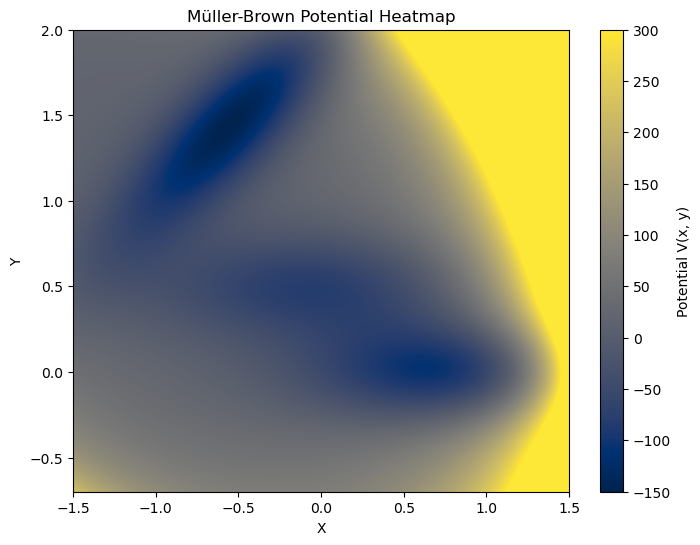

In [3]:
plot_muller_brown_heatmap()

In [4]:
@numba.njit
def langevin( n: int,T: float = 1.0, center: np.ndarray = None, k_spring_x: float = 1000.0, k_spring_y: float = 1000.0, bias_x: bool = False, bias_y: bool = False):
    """
    Langevin dynamics with conditional biasing potential for a single center.

    Parameters:
    - n (int): Number of steps.
    - T (float): Temperature.
    - center (numpy.ndarray): Biasing center with shape (2,).
    - k_spring_x (float): Spring constant for the bias along the x-axis.
    - k_spring_y (float): Spring constant for the bias along the y-axis.
    - bias_x (bool): Whether to apply bias along the x-axis.
    - bias_y (bool): Whether to apply bias along the y-axis.

    Returns:
    - positions (numpy.ndarray): Array of shape (n, 2) with positions.
    - bias_energies (numpy.ndarray): Array of shape (n, num_biased_dims) with biasing energies.
    """
    if center is None:
        center = np.zeros(2)  # Default center if none provided
    if center.shape != (2,):
        raise ValueError("Center must have shape (2,) to represent a 2D system.")

    # Determine the number of biased dimensions
    num_biased_dims = int(bias_x) + int(bias_y)

    # Initialize arrays
    positions = np.zeros((n, 2))  # Always 2D
    bias_energies = np.zeros((n, num_biased_dims))  # Dimension matches number of biases

    dt = 5e-4
    gamma = 1.0
    theta = np.exp(-gamma * dt)
    sigma = np.sqrt((1 - theta**2) * T)

    # Initialize position and velocity
    positions[0] = center
    vel = np.random.randn(2) * np.sqrt(T)
    _, dudx, dudy = mullerBrownPotentialAndGradient(positions[0])

    for i in numba.prange(n - 1):
        # Biasing forces (only applied if bias_x or bias_y is True)
        bias_dx = k_spring_x * (positions[i, 0] - center[0]) if bias_x else 0.0
        bias_dy = k_spring_y * (positions[i, 1] - center[1]) if bias_y else 0.0

        # Update velocities (half-step)
        force = np.array([-dudx, -dudy]) - np.array([bias_dx if bias_x else 0.0, bias_dy if bias_y else 0.0])
        vel += 0.5 * force * dt
        vel = theta * vel + sigma * np.random.randn(2)

        # Update positions
        positions[i + 1] = positions[i] + vel * dt

        # Update gradients
        _, dudx, dudy = mullerBrownPotentialAndGradient(positions[i + 1])

        # Compute bias potential energies
        energy_idx = 0
        if bias_x:
            bias_dx = k_spring_x * (positions[i + 1, 0] - center[0])
            bias_energies[i + 1, energy_idx] = 0.5 * bias_dx**2
            energy_idx += 1
        if bias_y:
            bias_dy = k_spring_y * (positions[i + 1, 1] - center[1])
            bias_energies[i + 1, energy_idx] = 0.5 * bias_dy**2

        # Update velocities (half-step)
        force = np.array([-dudx, -dudy]) - np.array(
            [bias_dx if bias_x else 0.0, bias_dy if bias_y else 0.0]
        )
        vel += 0.5 * force * dt

    return positions, bias_energies

### Molecular Dynamics Simulations on Müller-Brown Potential

In our molecular dynamics (MD) simulations, we started from two distinct states, A and B, on the Müller-Brown potential energy surface. State A is centered at coordinates \([-0.65, 1.3]\), while state B is centered at coordinates \([0.75, 0.0]\).

Despite running extensive simulations with \(10^6\) steps for each state, we observed no transitions between these two states. The trajectories remained confined to their respective basins, indicating that the energy barriers between these states are significant enough to prevent spontaneous transitions under the given simulation conditions. This observation highlights the stability of the states and the effectiveness of the Müller-Brown potential in modeling such energy landscapes.

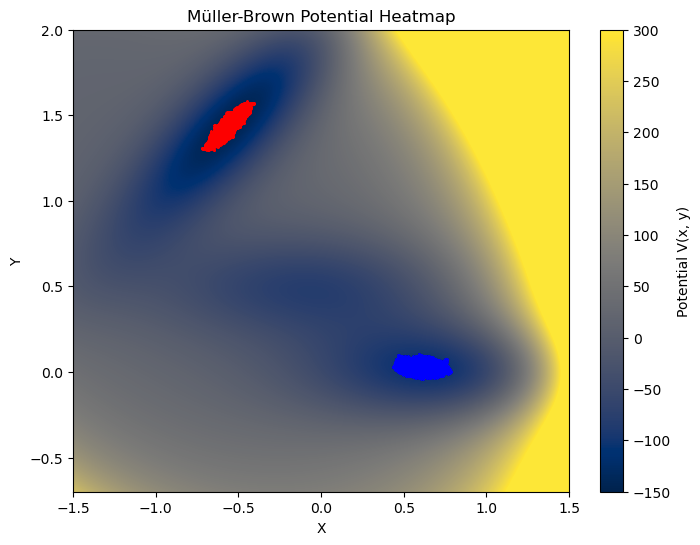

In [5]:

# Unbiased simulation
pos_A, _ = langevin(int(1e6), T=1.0, center=np.array([-0.65, 1.3]))
pos_B, _ = langevin(int(1e6), T=1.0, center=np.array([0.75, 0.0]))

fig, ax = plot_muller_brown_heatmap(return_fig=True)
ax.scatter(*pos_A.T, c='red', s=0.1)
ax.scatter(*pos_B.T, c='blue', s=0.1)


In contrast to molecular dynamics (MD) simulations, we can add a bias to force the system to be in a certain configuration. This bias is typically implemented as a harmonic potential that constrains the system around a predefined center. The biasing potential can be applied along one or more dimensions, and it helps in sampling regions of the potential energy surface that are otherwise difficult to access due to high energy barriers.

### Bias Parameters

- **center**: The coordinates around which the biasing potential is applied. This is a 2D array representing the x and y positions.
- **k_spring_x**: The spring constant for the bias along the x-axis. A higher value results in a stronger bias.
- **k_spring_y**: The spring constant for the bias along the y-axis. Similar to `k_spring_x`, a higher value results in a stronger bias.
- **bias_x**: A boolean flag indicating whether to apply the bias along the x-axis.
- **bias_y**: A boolean flag indicating whether to apply the bias along the y-axis.

### Effect of Defining a Center

By defining a center and applying the bias, we can force the system to explore configurations around this center. This is particularly useful in umbrella sampling, where multiple biased simulations are run with different centers to cover a wide range of configurations. The results from these simulations can then be combined to obtain a free energy profile.

The plot below shows the effect of defining a center and applying the bias. The red dot represents the bias center, and the trajectory of the system is shown as a line. The system is constrained around the bias center, allowing us to sample configurations that are otherwise difficult to access.

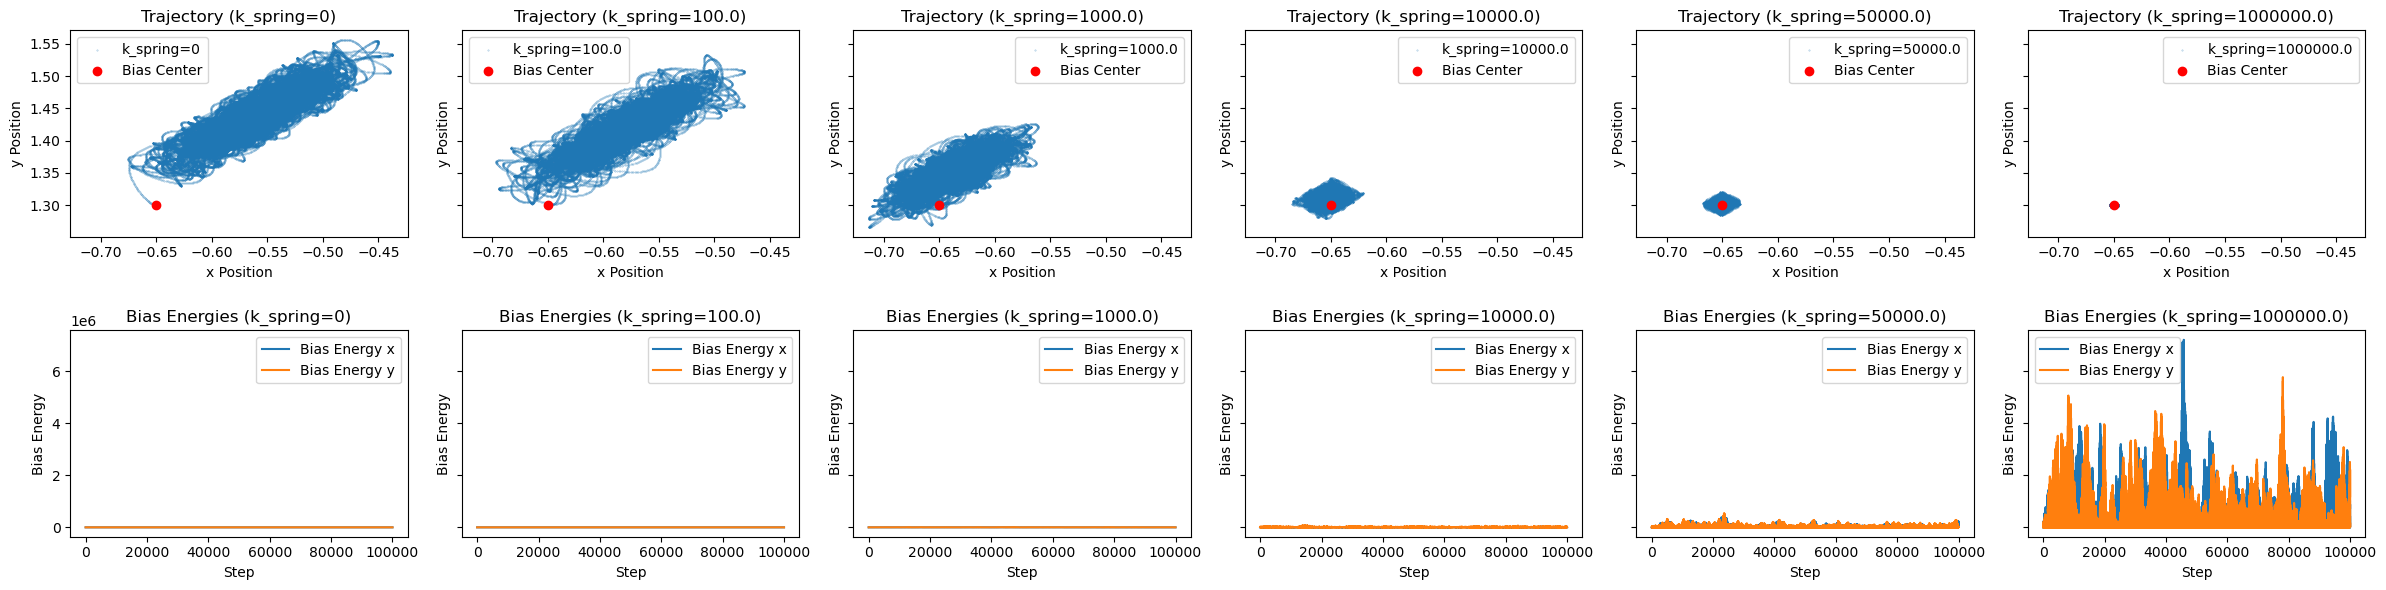

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for simulation
n_steps = int(1e5)
temperature = 1.0
bias_x = True
bias_y = True

# Define a single umbrella center
center = np.array([-0.65, 1.3])

# Spring constants to test
spring_constants = [0, 100.0, 1000.0, 10000.0, 50000.0,1000000.0]  # Different spring constants for comparison

# Collect results
results = []

for k_spring in spring_constants:
    # Simulate dynamics with different spring constants
    positions, bias_energies = langevin(
        n=n_steps,
        T=temperature,
        center=center,
        k_spring_x=k_spring,
        k_spring_y=k_spring,
        bias_x=bias_x,
        bias_y=bias_y,
    )
    results.append((k_spring, positions, bias_energies))

# Plot results
fig, axes = plt.subplots(2,len(spring_constants), figsize=(len(spring_constants)*4,6), sharex='row', sharey='row')

for i, (k_spring, positions, bias_energies) in enumerate(results):
    # Trajectory plot
    ax1 = axes[0,i]
    ax1.scatter(positions[:, 0], positions[:, 1], label=f"k_spring={k_spring}",alpha=0.5,s=0.1)
    ax1.scatter(center[0], center[1], color="red", label="Bias Center")
    ax1.set_title(f"Trajectory (k_spring={k_spring})")
    ax1.set_xlabel("x Position")
    ax1.set_ylabel("y Position")
    ax1.legend()
    
    # Bias energy plot
    ax2 = axes[1,i]
    ax2.plot(bias_energies[:, 0], label="Bias Energy x")
    ax2.plot(bias_energies[:, 1], label="Bias Energy y")
    ax2.set_title(f"Bias Energies (k_spring={k_spring})")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Bias Energy")
    ax2.legend()

plt.tight_layout()
plt.show()

### Free Energy Calculation Using Umbrella Sampling

To determine the free energy of the system, we can use a technique called **umbrella sampling**. Umbrella sampling is a powerful method used to enhance the sampling of states that are otherwise difficult to access due to high energy barriers. This technique involves applying a biasing potential to the system to force it to sample a predefined path or region of interest.

#### Steps in Umbrella Sampling:

1. **Define Umbrella Centers**: 
    - We define a series of centers along the path we want to sample. These centers act as reference points for the biasing potentials.
    - In our case, the path is defined between two points, `A_point` and `B_point`, and we interpolate `n_windows` umbrella centers along this path.

2. **Apply Biasing Potentials**:
    - For each umbrella center, we apply a harmonic biasing potential that constrains the system around the center. The biasing potential is typically of the form:
      \[
      V_{\text{bias}}(x) = \frac{1}{2} k_{\text{spring}} (x - x_{\text{center}})^2
      \]
    - Here, \( k_{\text{spring}} \) is the spring constant, and \( x_{\text{center}} \) is the position of the umbrella center.

3. **Run Simulations**:
    - We run separate simulations for each umbrella center, allowing the system to explore configurations around the center. The biasing potential ensures that the system samples the region of interest effectively.

4. **Collect Data**:
    - During the simulations, we collect data on the positions and biasing energies of the system. This data is used to compute the mean forces and positions for each umbrella window.

5. **Compute Free Energy Profiles**:
    - Using the collected data, we perform block analysis to compute the mean forces and positions for each umbrella window.
    - We then integrate the mean forces to obtain the free energy profile along the path.

6. **Combine Results**:
    - The free energy profiles from all umbrella windows are combined to obtain the overall free energy profile of the system.

By following these steps, we can determine the free energy landscape of the system, which provides valuable insights into the stability and transitions between different states.
This approach allows us to determine the free energy landscape of the system, providing insights into the stability and transitions between different states.

#### Step 1: Define a path for the umbrella windows

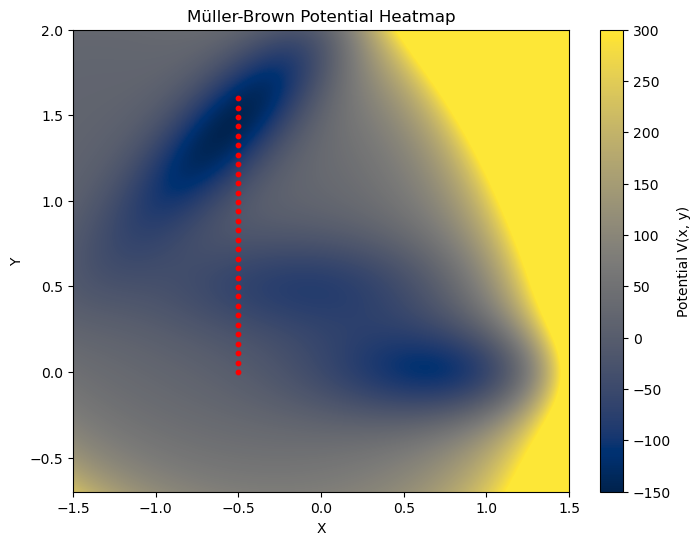

In [21]:
# Umbrella parameters
n_windows = 30
n_steps = int(1e6)
temperature = 1.0
k_spring_x = 10e3
k_spring_y = 10e3

# Bias boolean flags
bias_x = False
bias_y = True

# Define umbrella centers
x_centers = np.linspace(0.65, -.5, n_windows)  # Centers along x-axis
x_centers = np.array([-0.5]*n_windows)
y_centers = np.linspace(0.0, 1.6, n_windows)  # Centers along y-axis
centers = np.column_stack((x_centers, y_centers))  # Shape: (n_windows, 2)

fig, ax = plot_muller_brown_heatmap(return_fig=True)
ax.scatter(*centers.T, c='red', s=10)

#### Step 2 and 3: Do the umbrella sampling 

In [22]:
# Run umbrella sampling for each window
trajectories = []
bias_energies = []

for center in centers:
    print(f"Running simulation for center: {center}")
    traj, bias_energy = langevin(
        n=n_steps,
        T=temperature,
        center=center,
        k_spring_x=k_spring_x,
        k_spring_y=k_spring_y,
        bias_x=bias_x,
        bias_y=bias_y
    )
    trajectories.append(traj)
    bias_energies.append(bias_energy)

# Aggregate results
trajectories = np.array(trajectories)  # Shape: (num_windows, n_steps, 2)
bias_energies = np.array(bias_energies)  # Shape: (num_windows, n_steps)

Running simulation for center: [-0.5  0. ]
Running simulation for center: [-0.5         0.05517241]
Running simulation for center: [-0.5         0.11034483]
Running simulation for center: [-0.5         0.16551724]
Running simulation for center: [-0.5         0.22068966]
Running simulation for center: [-0.5         0.27586207]
Running simulation for center: [-0.5         0.33103448]
Running simulation for center: [-0.5        0.3862069]
Running simulation for center: [-0.5         0.44137931]
Running simulation for center: [-0.5         0.49655172]
Running simulation for center: [-0.5         0.55172414]
Running simulation for center: [-0.5         0.60689655]
Running simulation for center: [-0.5         0.66206897]
Running simulation for center: [-0.5         0.71724138]
Running simulation for center: [-0.5         0.77241379]
Running simulation for center: [-0.5         0.82758621]
Running simulation for center: [-0.5         0.88275862]
Running simulation for center: [-0.5         0.

### Visualize the sampling

Text(0, 0.5, 'Y Position')

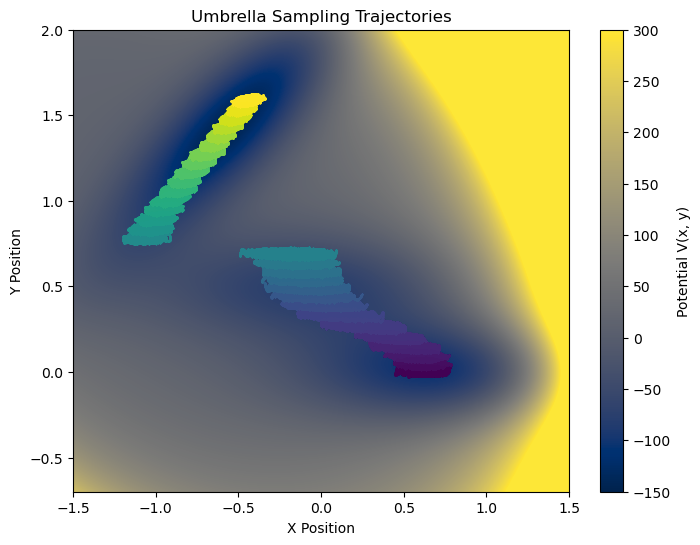

In [23]:
# Plotting the results
fig, ax = plot_muller_brown_heatmap(return_fig=True)
colors = plt.cm.viridis(np.linspace(0, 1, n_windows))

# Plot all trajectories in the same heatmap
for w in range(n_windows):
    positions = trajectories[w]
    # Skip the first 10,000 steps to avoid initial relaxation
    ax.scatter(positions[10000:, 0], positions[10000:, 1], s=0.1, color=colors[w], label=f"Window {w+1}")

ax.set_title("Umbrella Sampling Trajectories")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")


Text(0, 0.5, 'Frequency')

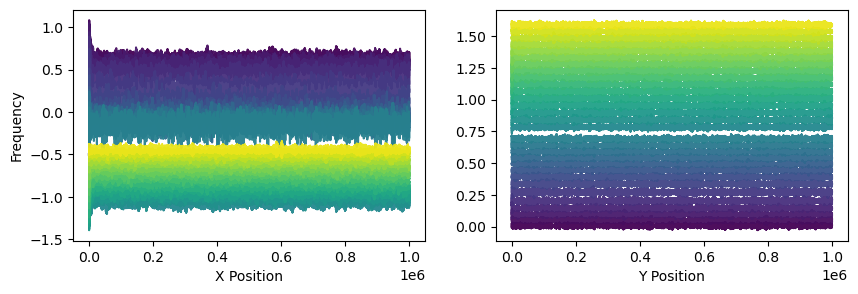

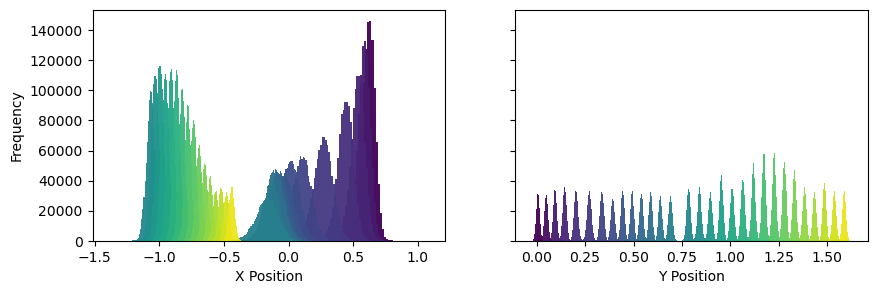

In [24]:
# Plot time traces for each window
fig, ax = plt.subplots(1,2,figsize=(10, 3),sharex=True) 

cmap = plt.cm.viridis    
for w in range(n_windows):
    positions = trajectories[w]
    ax[0].plot(positions[:, 0], alpha=0.95, label=f"Window {w+1}", color=cmap(w/n_windows))
    ax[1].plot(positions[:, 1], alpha=0.95, label=f"Window {w+1}", color=cmap(w/n_windows))
ax[0].set_xlabel("X Position")
ax[1].set_xlabel("Y Position")
ax[0].set_ylabel("Frequency")
#ax[1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize='small')


# Plot histograms for each window
fig, ax = plt.subplots(1,2,figsize=(10, 3),sharey=True) 

cmap = plt.cm.viridis    
for w in range(n_windows):
    positions = trajectories[w]
    ax[0].hist(positions[:, 0], bins=100, alpha=0.95, label=f"Window {w+1}", color=cmap(w/n_windows))
    ax[1].hist(positions[:, 1], bins=100, alpha=0.95, label=f"Window {w+1}", color=cmap(w/n_windows))
ax[0].set_xlabel("X Position")
ax[1].set_xlabel("Y Position")
ax[0].set_ylabel("Frequency")
#ax[1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize='small')

#### Step 4 and 5: Perform Block Averaging on the Forces and Compute Free Energy Profile (FES) Along the Path

Block averaging is a statistical technique used to reduce noise and estimate the mean and variance of a dataset. It involves dividing the data into blocks and computing the average for each block. This method helps in obtaining more reliable estimates by reducing the effects of correlated data points.

##### Steps for Block Averaging:

1. **Divide Data into Blocks**: Split the dataset into non-overlapping blocks of equal size.  
2. **Compute Block Averages**: Calculate the average value for each block.  
3. **Analyze Block Averages**: Use the block averages to estimate the mean and variance of the original dataset.  


#### Free Energy Profile (FES)

The free energy profile (FES) is a representation of the free energy landscape along a reaction coordinate or path. It provides insights into the stability and transitions between different states of a system.

##### Computing FES:

1. **Collect Forces**: Gather force data along the reaction coordinate.  
2. **Block Averaging**: Apply block averaging to the collected force data to reduce noise and obtain reliable force estimates.  
3. **Integrate Forces**: Integrate the averaged forces along the reaction coordinate to compute the free energy profile.


#### Theory Behind FES Calculation

The free energy $F(x)$ along a reaction coordinate $x$ can be computed using the following relationship:

$
F(x) = - \int \langle F(x') \rangle \, dx'
$

where $\langle F(x') \rangle$ is the average force at position $x'$.

##### Steps:

1. **Force Collection**: Measure the forces acting on the system at various points along the reaction coordinate.  
2. **Block Averaging**: Divide the force data into blocks and compute the average force for each block.  
3. **Integration**: Integrate the block-averaged forces to obtain the free energy profile.  


#### Example

Suppose you have force data $F(x)$ collected at discrete points along the reaction coordinate $x$. You can perform block averaging and compute the FES as follows:

1. **Divide the force data into blocks**:
   - Block 1: $\{ F_1, F_2, \ldots, F_n \}$  
   - Block 2: $\{ F_{n+1}, F_{n+2}, \ldots, F_{2n} \}$  
   - ...

2. **Compute the average force for each block**:
   $
   \langle F_{\text{block 1}} \rangle = \frac{1}{n} \sum_{i=1}^{n} F_i
   $
   $
   \langle F_{\text{block 2}} \rangle = \frac{1}{n} \sum_{i=n+1}^{2n} F_i
   $

3. **Integrate the block-averaged forces to obtain the FES**:
   $
   F(x) = - \int \langle F(x') \rangle \, dx'
   $

By following these steps, you can compute a smooth and reliable free energy profile that provides insights into the system's behavior along the reaction coordinate.

In [11]:
from scipy import integrate

def compute_block_analysis(trajectories, centers, blocksize, k_spring, dimension):
    """
    Perform block analysis for a given dimension (x or y).

    Args:
        trajectories: Array of shape (n_windows, n_samples, 2).
        centers: Array of shape (n_windows, 2).
        blocksize: Block size for averaging.
        k_spring: Spring constant for the given dimension.
        dimension: Index of the dimension (0 for x, 1 for y).

    Returns:
        forces: Array of mean forces per block.
        samples: Array of mean positions per block.
    """
    n_windows = len(centers)
    n_samples = trajectories.shape[1]
    n_blocks = n_samples // blocksize

    forces = np.zeros((n_blocks, n_windows))
    samples = np.zeros((n_blocks, n_windows))

    for c in range(n_windows):
        positions = trajectories[c, :, dimension]
        for b in range(n_blocks):
            block_data = positions[b * blocksize:(b + 1) * blocksize]
            forces[b, c] = np.mean(k_spring * (block_data - centers[c, dimension]))
            samples[b, c] = np.mean(block_data)

    return forces, samples


def compute_free_energy(mean_forces, centers, dimension):
    """
    Compute the free energy profile for a given dimension.
    Handles the case where centers are constant.

    Args:
        mean_forces: Array of mean forces.
        centers: Array of center positions.
        dimension: Index of the dimension (0 for x, 1 for y).

    Returns:
        fes: Free energy profile.
    """
    # Check for constant centers
    if np.all(np.isclose(centers[:, dimension], centers[0, dimension])):
        # Constant centers case: Return FES as a function of accumulated forces
        grid = np.linspace(-1, 1, len(mean_forces))  # Define an arbitrary grid
        fes = -1 *integrate.cumulative_trapezoid(mean_forces, grid, initial=0)
    else:
        # Standard integration
        fes = -1 *integrate.cumulative_trapezoid(mean_forces, centers[:, dimension], initial=0)

    # Normalize FES to start at zero
    fes -= fes[0]
    return fes


def compute_arc_lengths(centers):
    """
    Compute normalized arc lengths along the path of the centers.

    Args:
        centers: Array of shape (n_windows, 2).

    Returns:
        arc_lengths: Normalized arc lengths.
    """
    n_windows = len(centers)
    arc_lengths = np.zeros(n_windows)
    for i in range(1, n_windows):
        dx = centers[i, 0] - centers[i - 1, 0]
        dy = centers[i, 1] - centers[i - 1, 1]
        arc_lengths[i] = arc_lengths[i - 1] + np.sqrt(dx**2 + dy**2)
    arc_lengths /= arc_lengths[-1]  # Normalize to [0, 1]
    return arc_lengths


def plot_free_energy_profiles(fes_x, fes_y, centers, arc_lengths, bias_x, bias_y):
    """
    Plot the free energy profiles.

    Args:
        fes_x: Free energy profile along x.
        fes_y: Free energy profile along y.
        centers: Array of shape (n_windows, 2).
        arc_lengths: Normalized arc lengths.
        bias_x: Boolean flag for bias in x.
        bias_y: Boolean flag for bias in y.
    """
    
    if bias_x and bias_y:
        fes_sum = fes_x + fes_y
    elif bias_x:
        fes_sum = fes_x
    elif bias_y:
        fes_sum = fes_y
    
    n_plots = sum([bool(bias_x), bool(bias_y), fes_sum is not None])
    _, axes = plt.subplots(1, n_plots, figsize=(9, 3), constrained_layout=True, sharey=True)
    axes = [axes] if n_plots == 1 else axes
    plot_idx = 0

    if bias_x:
        axes[plot_idx].plot(centers[:, 0], fes_x, label="FES_x")
        axes[plot_idx].set_xlabel("x")
        axes[plot_idx].set_ylabel("Free Energy")
        axes[plot_idx].set_title("FES along x")
        plot_idx += 1

    if bias_y:
        axes[plot_idx].plot(centers[:, 1], fes_y, label="FES_y")
        axes[plot_idx].set_xlabel("y")
        axes[plot_idx].set_ylabel("Free Energy")
        axes[plot_idx].set_title("FES along y")
        plot_idx += 1

    if fes_sum is not None:
        axes[plot_idx].plot(arc_lengths, fes_sum, label=" FES_xy")
        axes[plot_idx].set_xlabel("Arc Length")
        axes[plot_idx].set_ylabel("Free Energy")
        axes[plot_idx].set_title("FES along xy")
    return fes_sum

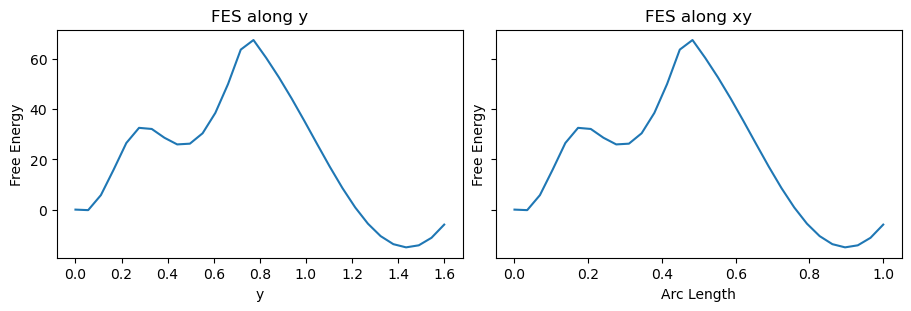

In [25]:
# Define blocksize for block analysis
blocksize = 500
forces_x, samples_x = compute_block_analysis(trajectories, centers, blocksize, k_spring_x, 0)
forces_y, samples_y = compute_block_analysis(trajectories, centers, blocksize, k_spring_y, 1)

# Compute mean forces and samples
mean_forces_x = np.mean(forces_x, axis=0) if bias_x else None
mean_samples_x = np.mean(samples_x, axis=0) if bias_x else None
mean_forces_y = np.mean(forces_y, axis=0) if bias_y else None
mean_samples_y = np.mean(samples_y, axis=0) if bias_y else None

# Compute free energy profiles
fes_x = compute_free_energy(mean_forces_x, centers, 0) if bias_x else None
fes_y = compute_free_energy(mean_forces_y, centers, 1) if bias_y else None
arc_lengths = compute_arc_lengths(centers)

# Plot free energy profiles
fes_sum = plot_free_energy_profiles(fes_x, fes_y, centers, arc_lengths, bias_x, bias_y)

### Comparison of Umbrella Sampling (US) and Nudged Elastic Band (NEB) Methods

The Umbrella Sampling (US) method was successful in sampling the free energy surface (FES) of the system. However, it did not follow the Minimum Energy Path (MEP). The Nudged Elastic Band (NEB) method is designed to find the MEP, but it requires precise information about the underlying potential energy surface.

Despite this, we can still compare the FES obtained from the NEB method with the FES from our US simulations. This comparison provides insights into the accuracy and effectiveness of both methods in capturing the free energy landscape of the system.

#### Steps in the NEB Method:

1. **Define Initial and Final States**:
    - Define the initial and final states of the system.
    - Generate a series of intermediate states (images) between the initial and final states. These images form a chain or band connecting the two states.

2. **Introduce Spring Forces**:
    - Introduce spring forces between adjacent images to maintain even spacing along the path. This prevents images from clustering together or drifting apart.
    - The spring force ($F_{\text{spring}}$) is defined as:

    $
    F_{\text{spring}} = k (R_{i+1} - R_i) - k (R_i - R_{i-1})
    $
  
    Here:
    - $k$: the spring constant.
    - $R_i$: the position of the $i$-th image.
3. **Calculate Perpendicular Forces**:
    - Calculate the true force acting on each image due to the potential energy surface.
    - Project out the component of this force that is parallel to the path to prevent images from sliding along the path. Only the perpendicular component of the force is used to adjust the positions of the images.
    - The perpendicular force ($F_{\perp}$) is given by:

      $
      F_{\perp} = - \nabla V(R_i) + (\nabla V(R_i) \cdot \hat{\tau}_i) \hat{\tau}_i
      $

      Here:
      - $\nabla V(R_i)$: the gradient of the potential energy at the $i$-th image.
      - $\hat{\tau}_i$: the unit tangent vector to the path at the $i$-th image.

4. **Iterative Optimization**:
    - Adjust the positions of the images iteratively using the combined spring and perpendicular forces.
    - Continue this process until the forces on all images converge to zero, indicating that the MEP has been found.

5. **Analyze Results**:
    - The final positions of the images represent the MEP.
    - The energy profile along the MEP can be analyzed to understand the transition states and energy barriers between the initial and final states.

By following these steps, the NEB method effectively finds the MEP, providing valuable insights into the transition mechanisms and energy landscape of the system.


In [13]:
@numba.jit(nopython=True)
def norm(vec):
    """
    Computes the Euclidean norm of a vector.
    
    Parameters:
    - vec (numpy.ndarray): Input vector.

    Returns:
    - float: The Euclidean norm.
    """
    return np.sqrt(np.sum(vec ** 2))

@numba.njit
def compute_neb_forces(images, k=1.0, max_force=5.0):
    """
    Computes the NEB forces for a given set of images using JIT for acceleration.
    
    Parameters:
    - images (numpy.ndarray): Positions of images along the path.
    - k (float): Spring constant.
    - max_force (float): Maximum allowed force magnitude.

    Returns:
    - forces (numpy.ndarray): Forces on each intermediate image.
    """
    n_images = len(images)
    forces = np.zeros((n_images - 2, 2))  # Forces for intermediate images only
    
    for i in numba.prange(1, n_images - 1):
        # Tangent vector
        t_i = images[i + 1] - images[i - 1]
        t_i /= norm(t_i)

        # Spring force
        delta_prev = images[i] - images[i - 1]
        delta_next = images[i + 1] - images[i]
        spring_force = k * (norm(delta_next) - norm(delta_prev)) * t_i

        # True force
        _, grad_dx, grad_dy = mullerBrownPotentialAndGradient(images[i])
        grad = np.array([grad_dx, grad_dy])

        # Perpendicular component
        grad_parallel = np.dot(grad, t_i) * t_i
        grad_perpendicular = grad - grad_parallel

        # Total force
        f_total = spring_force - grad_perpendicular

        # Gradient clipping
        force_magnitude = norm(f_total)
        if force_magnitude > max_force:
            f_total = f_total / force_magnitude * max_force

        forces[i - 1] = f_total
    return forces

@numba.jit(nopython=True, parallel=True)
def update_images(images, forces, learning_rate=0.001):
    """
    Updates the positions of the images along the NEB path based on computed forces.
    
    Parameters:
    - images (numpy.ndarray): Current positions of the images.
    - forces (numpy.ndarray): Forces acting on each intermediate image.
    - learning_rate (float): Step size for updating image positions.
    
    Returns:
    - new_images (numpy.ndarray): Updated positions of the images.
    """
    new_images = images.copy()
    for i in numba.prange(1, len(images) - 1):
        new_images[i] += learning_rate * forces[i - 1]

        # Constrain x and y within bounds
        if new_images[i][0] < -1.5:
            new_images[i][0] = -1.5
        elif new_images[i][0] > 1.5:
            new_images[i][0] = 1.5

        if new_images[i][1] < -0.7:
            new_images[i][1] = -0.7
        elif new_images[i][1] > 2.0:
            new_images[i][1] = 2.0
    return new_images

Converged after 3496 iterations.


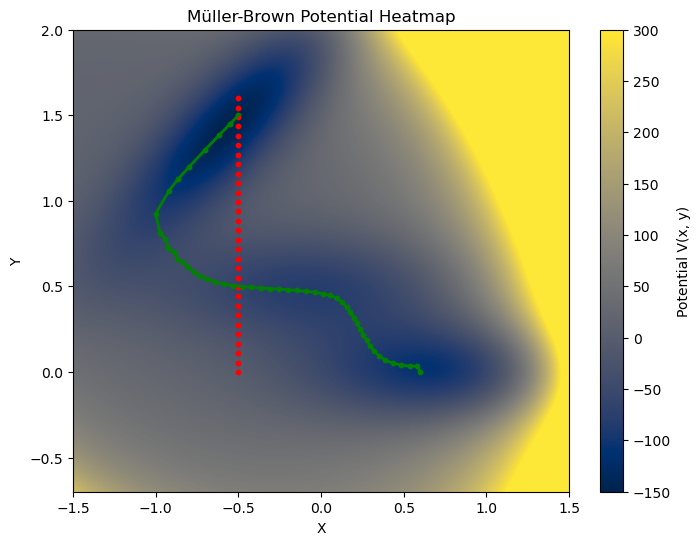

In [26]:
# Parameters
N_images = 50
A_point = np.array([0.6, 0.0])
B_point = np.array([-0.5, 1.5])
images = np.linspace(A_point, B_point, N_images)

# NEB Optimization
max_iterations = int(1e5)
tolerance = 0.1
learning_rate = 0.00005

for iteration in range(max_iterations):
    forces = compute_neb_forces(images, k=1.0, max_force=5.0)
    max_force_mag = max(norm(f) for f in forces)
    if max_force_mag < tolerance:
        print(f'Converged after {iteration} iterations.')
        break
    images = update_images(images, forces, learning_rate=learning_rate)
else:
    print('NEB did not converge within the maximum number of iterations.')

#  Extract free energy profile
energies = np.array([mullerBrownPotential(pos[0], pos[1]) for pos in images])

# Visualization
path = np.array(images)
fig,  ax  = plot_muller_brown_heatmap(cmap='cividis', vmin=-150, vmax=300, return_fig=True)
ax.plot(path[:, 0], path[:, 1],color='green', lw=2)
ax.scatter(path[:, 0], path[:, 1], color='green', s=10)
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=10)
plt.show()

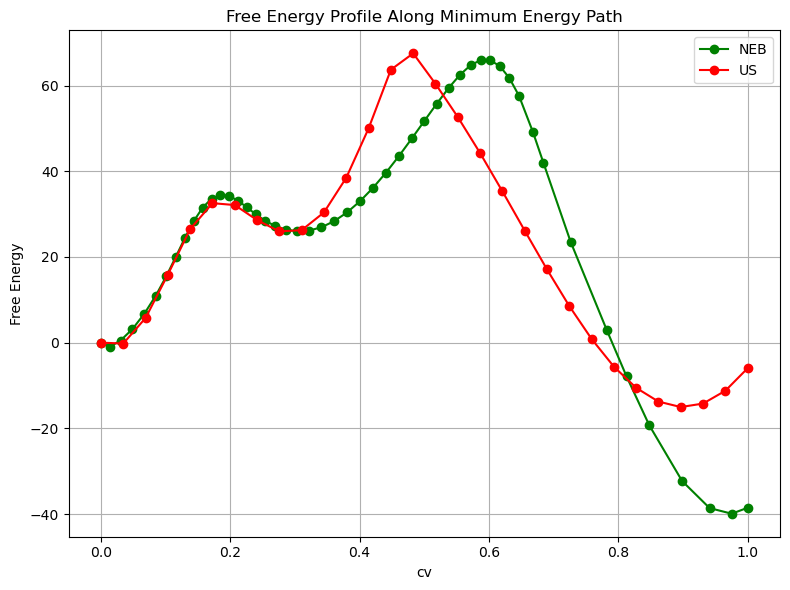

In [27]:
# Compute Boltzmann probabilities
boltzmann_weights = np.exp(-energies / temperature)
probabilities = boltzmann_weights / np.sum(boltzmann_weights)

# Compute reweighted free energy
energies = -temperature * np.log(probabilities)

# convert path to arc length
arc_lengths_neb = np.zeros(N_images)
for i in range(1, N_images):
    dx = images[i, 0] - images[i - 1, 0]
    dy = images[i, 1] - images[i - 1, 1]
    arc_lengths_neb[i] = arc_lengths_neb[i - 1] + np.sqrt(dx**2 + dy**2)
arc_lengths_neb /= arc_lengths_neb[-1]

# Plot the free energy profile
plt.figure(figsize=(8, 6))
plt.plot(arc_lengths_neb, energies-energies[0], 'o-', label='NEB',color='green')
plt.xlabel('Image Index')
plt.ylabel('Potential Energy (a.u.)')
plt.title('Free Energy Profile Along Minimum Energy Path')
plt.grid()
plt.legend()
plt.tight_layout()


# Plot the free energy profile
plt.plot(arc_lengths, fes_sum, 'ro-', label='US')
plt.xlabel("cv")
plt.ylabel("Free Energy")
plt.legend()
plt.show()

### Optional Assignment:

In this optional assignment, you will compute the Free Energy Surface (FES) along the Minimum Energy Path (MEP) obtained via the Nudged Elastic Band (NEB) method using Umbrella Sampling (US). This exercise will help you understand the process of combining different computational techniques to achieve a comprehensive understanding of the energy landscape of a system.

#### Steps to consider:

- Use the MEP obtained from the NEB method to define a series of umbrella centers.
- Interpolate these centers along the MEP to ensure they are evenly spaced.
- Compare the FES obtained from the US method with the FES from the NEB method.
- Analyze the differences and similarities between the two profiles to understand the effectiveness of each method.

By completing this assignment, you will gain hands-on experience in using advanced computational techniques to explore the energy landscape of a system. This knowledge is crucial for understanding the stability and transitions between different states in molecular dynamics simulations.

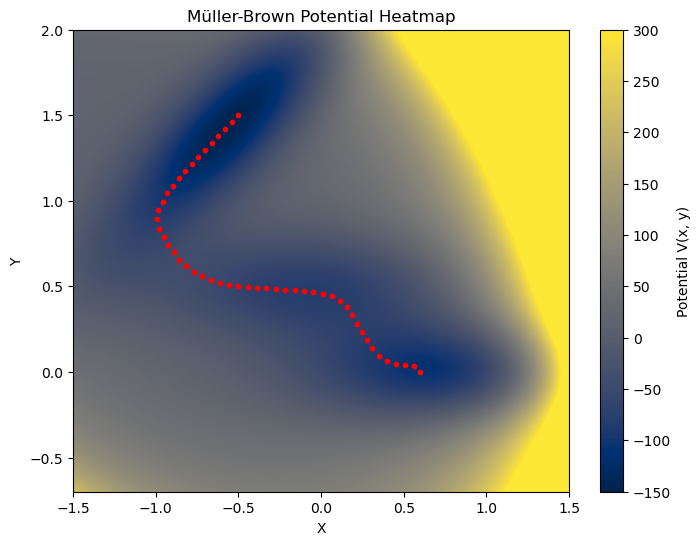

In [16]:
# Umbrella parameters
n_windows = 50
n_steps = int(1e6)
temperature = 1.0
k_spring_x = 10e3
k_spring_y = 10e3


# Bias boolean flags
bias_x = True
bias_y = True


# Compute cumulative arc length of NEB path
distances = np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1))
cumulative_length = np.concatenate([[0], np.cumsum(distances)])
total_length = cumulative_length[-1]

# Normalize arc length to [0, 1]
normalized_length = cumulative_length / total_length

# Define interpolation points based on number of windows
interp_points = np.linspace(0, 1, n_windows)

# Interpolate x and y centers based on normalized arc length
x_centers = np.interp(interp_points, normalized_length, path[:, 0])
y_centers = np.interp(interp_points, normalized_length, path[:, 1])
centers = np.column_stack((x_centers, y_centers))
centers = np.column_stack((x_centers, y_centers))

fig, ax = plot_muller_brown_heatmap(return_fig=True)
ax.scatter(*centers.T, c='red', s=10)

In [17]:
# Run umbrella sampling for each window
trajectories = []
bias_energies = []

for center in centers:
    print(f"Running simulation for center: {center}")
    traj, bias_energy = langevin(
        n=n_steps,
        T=temperature,
        center=center,
        k_spring_x=k_spring_x,
        k_spring_y=k_spring_y,
        bias_x=bias_x,
        bias_y=bias_y
    )
    trajectories.append(traj)
    bias_energies.append(bias_energy)

# Aggregate results
trajectories = np.array(trajectories)  # Shape: (num_windows, n_steps, 2)
bias_energies = np.array(bias_energies)  # Shape: (num_windows, n_steps)



Running simulation for center: [0.6 0. ]
Running simulation for center: [0.56349865 0.03431231]
Running simulation for center: [0.50670568 0.03824171]
Running simulation for center: [0.45053258 0.04805877]
Running simulation for center: [0.39642672 0.06565912]
Running simulation for center: [0.34844979 0.0960468 ]
Running simulation for center: [0.30942103 0.1375408 ]
Running simulation for center: [0.27613046 0.18382105]
Running simulation for center: [0.24674285 0.23271457]
Running simulation for center: [0.21856586 0.28232405]
Running simulation for center: [0.18931487 0.33129782]
Running simulation for center: [0.15660174 0.3779981 ]
Running simulation for center: [0.11553088 0.41721797]
Running simulation for center: [0.06527333 0.44343643]
Running simulation for center: [0.01016035 0.45778306]
Running simulation for center: [-0.04627431  0.46612732]
Running simulation for center: [-0.1029833   0.47236014]
Running simulation for center: [-0.15981724  0.4773401 ]
Running simulation

Text(0, 0.5, 'Frequency')

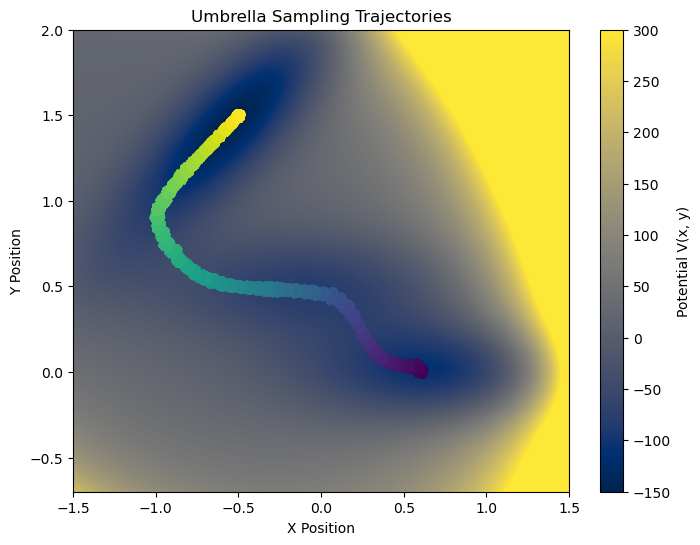

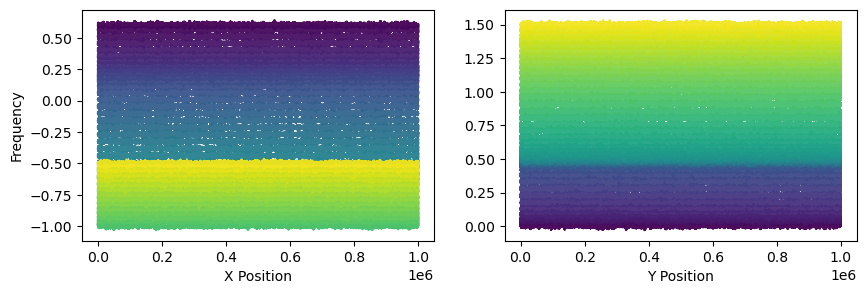

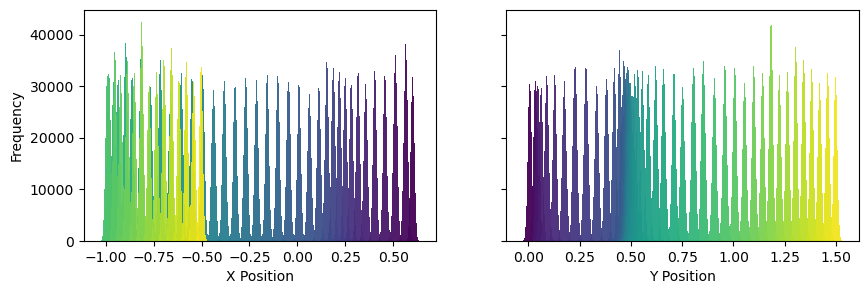

In [18]:
# Plotting the results
fig, ax = plot_muller_brown_heatmap(return_fig=True)
colors = plt.cm.viridis(np.linspace(0, 1, n_windows))

# Plot all trajectories in the same heatmap
for w in range(n_windows):
    positions = trajectories[w]
    # Skip the first 10,000 steps to avoid initial relaxation
    ax.scatter(positions[10000:, 0], positions[10000:, 1], s=0.1, color=colors[w], label=f"Window {w+1}")

ax.set_title("Umbrella Sampling Trajectories")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

# Plot time traces for each window
fig, ax = plt.subplots(1,2,figsize=(10, 3),sharex=True) 

cmap = plt.cm.viridis    
for w in range(n_windows):
    positions = trajectories[w]
    ax[0].plot(positions[:, 0], alpha=0.95, label=f"Window {w+1}", color=cmap(w/n_windows))
    ax[1].plot(positions[:, 1], alpha=0.95, label=f"Window {w+1}", color=cmap(w/n_windows))
ax[0].set_xlabel("X Position")
ax[1].set_xlabel("Y Position")
ax[0].set_ylabel("Frequency")
#ax[1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize='small')


# Plot histograms for each window
fig, ax = plt.subplots(1,2,figsize=(10, 3),sharey=True) 

cmap = plt.cm.viridis    
for w in range(n_windows):
    positions = trajectories[w]
    ax[0].hist(positions[:, 0], bins=100, alpha=0.95, label=f"Window {w+1}", color=cmap(w/n_windows))
    ax[1].hist(positions[:, 1], bins=100, alpha=0.95, label=f"Window {w+1}", color=cmap(w/n_windows))
ax[0].set_xlabel("X Position")
ax[1].set_xlabel("Y Position")
ax[0].set_ylabel("Frequency")
#ax[1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize='small')

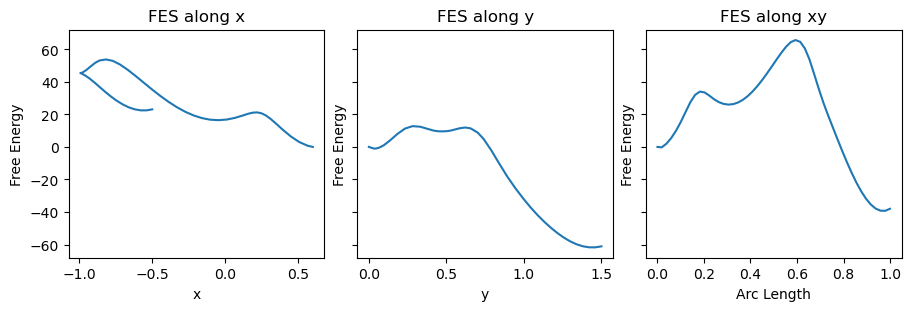

In [19]:
# Define blocksize for block analysis
blocksize = 500
forces_x, samples_x = compute_block_analysis(trajectories, centers, blocksize, k_spring_x, 0)
forces_y, samples_y = compute_block_analysis(trajectories, centers, blocksize, k_spring_y, 1)

# Compute mean forces and samples
mean_forces_x = np.mean(forces_x, axis=0) if bias_x else None
mean_samples_x = np.mean(samples_x, axis=0) if bias_x else None
mean_forces_y = np.mean(forces_y, axis=0) if bias_y else None
mean_samples_y = np.mean(samples_y, axis=0) if bias_y else None

# Compute free energy profiles
fes_x = compute_free_energy(mean_forces_x, centers, 0) if bias_x else None
fes_y = compute_free_energy(mean_forces_y, centers, 1) if bias_y else None
arc_lengths = compute_arc_lengths(centers)

# Plot free energy profiles
fes_sum = plot_free_energy_profiles(fes_x, fes_y, centers, arc_lengths, bias_x, bias_y)

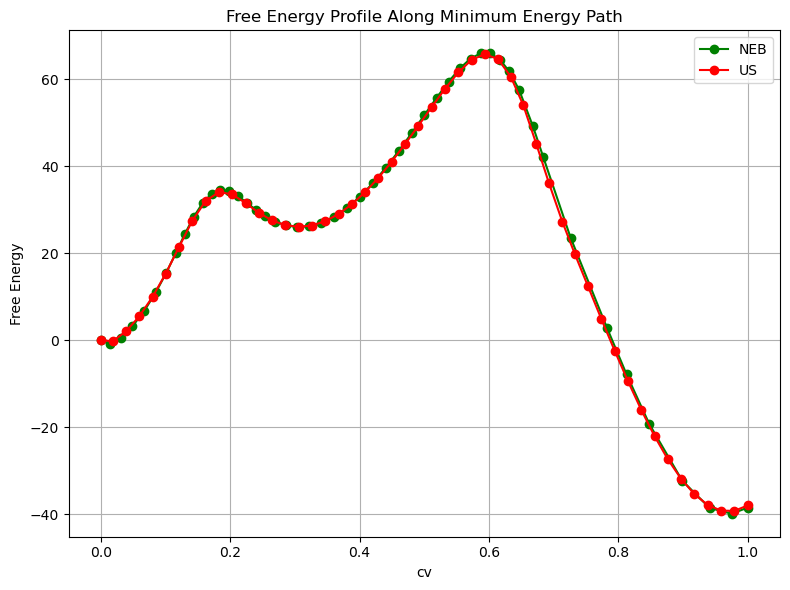

In [20]:
# Plot the free energy profile
plt.figure(figsize=(8, 6))
plt.plot(arc_lengths_neb, energies-energies[0], 'o-', label='NEB',color='green')
plt.xlabel('Image Index')
plt.ylabel('Potential Energy (a.u.)')
plt.title('Free Energy Profile Along Minimum Energy Path')
plt.grid()
plt.legend()
plt.tight_layout()


# Plot the free energy profile
plt.plot(arc_lengths, fes_sum, 'ro-', label='US')
plt.xlabel("cv")
plt.ylabel("Free Energy")
plt.legend()
plt.show()